<a href="https://colab.research.google.com/github/ChrisW2420/FedDistill/blob/main/Copy_of_knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation

**Author:** [Kenneth Borup](https://twitter.com/Kennethborup)<br>
**Date created:** 2020/09/01<br>
**Last modified:** 2020/09/01<br>
**Description:** Implementation of classical Knowledge Distillation.

## Introduction to Knowledge Distillation

Knowledge Distillation is a procedure for model
compression, in which a small (student) model is trained to match a large pre-trained
(teacher) model. Knowledge is transferred from the teacher model to the student
by minimizing a loss function, aimed at matching softened teacher logits as well as
ground-truth labels.

The logits are softened by applying a "temperature" scaling function in the softmax,
effectively smoothing out the probability distribution and revealing
inter-class relationships learned by the teacher.

**Reference:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

## Setup

In [1]:
!pip install --upgrade keras
!pip install --upgrade tensorflow wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [21]:
import os
import math
from tensorflow import keras
from keras import layers
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from keras.applications import ResNet50
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

wandb.login()

True

In [ ]:
# configs = dict(
#     num_classes = 10,
#     shuffle_buffer = 1024,
#     batch_size = 64,
#     image_size = 28,
#     image_channels = 1,
#     earlystopping_patience = 3,
#     learning_rate = 1e-3,
#     epochs = 3
# )

## Construct `Distiller()` class

The custom `Distiller()` class, overrides the `Model` methods `compile`, `compute_loss`,
and `call`. In order to use the distiller, we need:

- A trained teacher model
- A student model to train
- A student loss function on the difference between student predictions and ground-truth
- A distillation loss function, along with a `temperature`, on the difference between the
soft student predictions and the soft teacher labels
- An `alpha` factor to weight the student and distillation loss
- An optimizer for the student and (optional) metrics to evaluate performance

In the `compute_loss` method, we perform a forward pass of both the teacher and student,
calculate the loss with weighting of the `student_loss` and `distillation_loss` by `alpha`
and `1 - alpha`, respectively. Note: only the student weights are updated.

In [22]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)


## CNN models

In [17]:
# small
def smallCNN():
  smallCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="smallcnn",
  )
  return smallCNN

# medium
def mediumCNN():
  mediumCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return mediumCNN

# big
def bigCNN():
  bigCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return bigCNN

## Prepare the dataset

The dataset used for training the teacher and distilling the teacher is
[MNIST](https://keras.io/api/datasets/mnist/), and the procedure would be equivalent for
any other
dataset, e.g. [CIFAR-10](https://keras.io/api/datasets/cifar10/), with a suitable choice
of models. Both the student and teacher are trained on the training set and evaluated on
the test set.

In [18]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))


## Create student and teacher models

In [28]:
def train_CNN(model, _epoch, _name):
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
  )
  run = wandb.init(
    project = "kdbasicexpr",
    config = {"architecture": "CNN",
              "dataset": "MNIST",
              "epochs": _epoch,
              },
    # run name
    name = _name
  )
  # Train and evaluate teacher on data.
  model.fit(x_train, y_train, epochs=_epoch,validation_data=(x_test, y_test), callbacks=[WandbMetricsLogger()])
  eval_metrics = model.evaluate(x_test, y_test)
  run.finish()
  return model, eval_metrics

def train_distill(_student, _teacher, _epoch, _alpha, _temp, _name):
  distiller = Distiller(student=_student, teacher=_teacher)
  distiller.compile(
      optimizer=keras.optimizers.Adam(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=_alpha,
      temperature=_temp,
  )

  run = wandb.init(
    project = "kdbasic",
    config = {"architecture": "CNN",
              "dataset": "MNIST",
              "epochs": _epoch,
              },
    # run name
    name = _name
  )
  # Distill teacher to student

  distiller.fit(x_train, y_train, epochs=_epoch, validation_data=(x_test, y_test), callbacks=[WandbMetricsLogger()])
  eval_metrics = distiller.evaluate(x_test, y_test)
  run.finish()
  return distiller, eval_metrics

def cm_plot(model):
  # Preprocess the data
  y_test_cm = to_categorical(y_test, 10)
  # Predict the test set
  predictions = model.predict(x_test)

  # Convert predictions to class labels
  predicted_classes = np.argmax(predictions, axis=1)
  actual_classes = np.argmax(y_test_cm, axis=1)

  # Generate the confusion matrix
  cm = confusion_matrix(actual_classes, predicted_classes)
  cm = (cm/ cm.sum(axis=1))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm.round(2), display_labels=['0', '1','2','3','4','5','6','7','8','9'])
  disp.plot()
  plt.show()

  print(cm.diagonal() / cm.sum(axis=1))

# Experiments

## Compare the performance with same student and teacher model


In [29]:
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []
combo = []
for idx, m in enumerate(CNNls):
  t_config = m.get_config()
  s_config = m.get_config()
  t_model = keras.models.Sequential.from_config(t_config)
  d_model = keras.models.Sequential.from_config(s_config)
  s_model = keras.models.Sequential.from_config(s_config)
  teacher, teval = train_CNN(t_model, 10, 'teacher'+CNNnames[idx])
  distill, deval = train_distill(d_model, teacher, 10, 0.1, 5, 'distill'+CNNnames[idx])
  student, seval = train_CNN(s_model, 10, 'rawstu'+CNNnames[idx])
  output.append([teval, deval, seval])
  if seval[1] < deval[1]:
    combo.append(CNNnames[idx], CNNnames[idx])
print(output)
print(combo)

Problem at: <ipython-input-28-0689c07312b1> 7 train_CNN


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1181, in init
    run = wi.init()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 616, in init
    manager._inform_init(
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_manager.py", line 200, in _inform_init
    svc_iface._svc_inform_init(settings=settings, run_id=run_id)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/service/service_sock.py", line 39, in _svc_inform_init
    self._sock_client.send(inform_init=inform_init)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 211, in send
    self.send_server_request(server_req)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 155, in send_server_request
    self._send_message(msg)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/sock_client.py", line 152, in _send_message
    self._sendall

Error: An unexpected error occurred

## Compare the performance between with and without KD

In [ ]:
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []
combo = []
for idx_t, t in enumerate(CNNls):
  t_config = t.get_config()
  for idx_s ,s in enumerate(CNNls):
    s_config = s.get_config()
    t_model = keras.models.Sequential.from_config(t_config)
    d_model = keras.models.Sequential.from_config(s_config)
    s_model = keras.models.Sequential.from_config(s_config)
    teacher, teval = train_CNN(t_model, 5)
    distill, deval = train_distill(d_model, teacher, 3, 0.1, 5)
    student, seval = train_CNN(s_model, 3)
    output.append([teval, deval, seval])
    if seval[1] < deval[1]:
      combo.append(CNNnames[idx_t], CNNnames[idx_s])
print(output)
print(combo)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6794 - sparse_categorical_accuracy: 0.7937
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.9476
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.9619
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1146 - sparse_categorical_accuracy: 0.9647
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.9687
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.9654
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.9654
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.7333 - sparse_categorical_accuracy: 0.7040
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9497
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0221 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


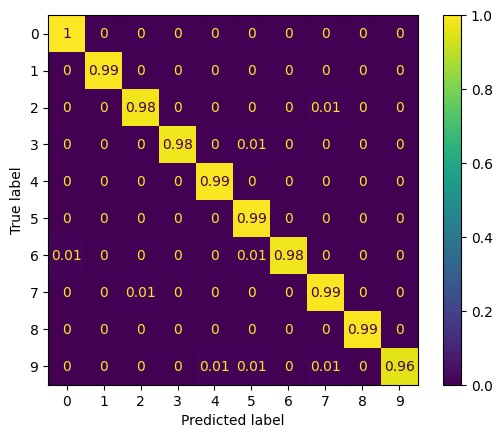

[0.99695665 0.99409003 0.98334669 0.97812723 0.99013456 0.99092707
 0.9784044  0.98549561 0.98563031 0.96361414]


In [ ]:
# Preprocess the data
y_test_cm = to_categorical(y_test, 10)
# Predict the test set
predictions = teacher.predict(x_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test_cm, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)
cm = (cm/ cm.sum(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm.round(2), display_labels=['0', '1','2','3','4','5','6','7','8','9'])
disp.plot()
plt.show()

print(cm.diagonal() / cm.sum(axis=1))

## observe model weights

In [ ]:
Tweights, Tbiases =  teacher.layers[-1].get_weights()
# Dweights, Dbiases =  distiller.layers[-1].get_weights()
Sweights, Sbiases =  student_scratch.layers[-1].get_weights()

print("Weights of the output layer:\n", Tweights, Sweights)
print("Biases of the output layer:\n", Tbiases, Sbiases)

Weights of the output layer:
 [[ 0.1394549  -0.00424952  0.09599148 ...  0.23841085 -0.06017627
  -0.0249629 ]
 [ 0.24516042  0.06631715 -0.16127941 ... -0.25794384  0.27884018
   0.2643842 ]
 [ 0.18706723 -0.6165633  -0.1586415  ... -0.26791924 -0.00648287
   0.17354843]
 ...
 [-0.39510736 -0.45938048  0.35964316 ... -0.17689064  0.25126883
   0.09409092]
 [-0.41765693 -0.01680286  0.07312652 ...  0.12978503  0.18897396
  -0.33629167]
 [ 0.03432905 -0.32070976 -0.35578766 ...  0.17976171 -0.0200269
   0.00693635]] [[-0.09021454 -0.07098527 -0.05728453 ... -0.11388993 -0.03257424
  -0.09754462]
 [ 0.07376936  0.1141155  -0.06223818 ... -0.09451519  0.0975888
   0.14076512]
 [ 0.04146593 -0.07241505  0.0007681  ... -0.02884299  0.03016947
  -0.00308976]
 ...
 [ 0.09587643 -0.07799426  0.16460563 ...  0.04809425 -0.25675476
  -0.02816536]
 [ 0.06399062  0.08341114  0.03668668 ...  0.02143194 -0.12983309
  -0.01744191]
 [ 0.0602922   0.11237707 -0.08031515 ... -0.04815526 -0.01092417
   0

## Find the most suitable param for each model combimation

## SIMKD

In [ ]:
def train_simKD(teacher, student, _epoch, _alpha, _temp):
  t_weights = teacher.layers[-1].get_weights()[0]
  s_weights = student.layers[-1].get_weights()[0]
  # Spatial Dimension Alignment
  t_classifier = keras.layers.Reshape(s_weights.shape)(t_weights)
  student.layers[-1].set_weights(t_classifier)
  # Freeze the last layer (prevent it from updating)
  student.layers[-1].trainable = False
  return train_distill(student, teacher, _epoch, _alpha, _temp)



In [ ]:
student = smallCNN()
t_weights = teacher.layers[-1].get_weights()[0]
s_weights = student.layers[-1].get_weights()[0]
print(t_weights.shape, s_weights.shape)
poolsize = math.ceil(s_weights.shape[0]/t_weights.shape[0])
tmp = keras.Sequential([l for l in student.layers[:-1], layers.MaxPooling2D(pool_size=(poolsize, poolsize), strides=(1, 1), padding="same"), student.layers[-1],], name = 'simkd')


print(t_weights.shape, tmp.shape)
# # Spatial Dimension Alignment
# student.layers[-1].set_weights(t_classifier)
# # Freeze the last layer (prevent it from updating)
# student.layers[-1].trainable = False
# train_distill(student, teacher, 3, 0.1, 5)

SyntaxError: invalid syntax (<ipython-input-39-1068b7c82c52>, line 6)

In [ ]:
# t_model = mediumCNN()
d_model = smallCNN()
s_model = smallCNN()
simmodel = smallCNN()
# teacher, teval = train_CNN(t_model, 5)
simkdmodel, simkdeval = train_simKD(simmodel, teacher, 3, 0.1, 5)
distill, deval = train_distill(d_model, teacher, 3, 0.1, 5)
student, seval = train_CNN(s_model, 3)
print(teval, deval, seval, simkdeval)

ValueError: The total size of the tensor must be unchanged. Received: input_shape=(10,), target_shape=(256, 10)

In [ ]:
teacher_weights, teacher_bias = teacher.layers[-1].get_weights()

print(teacher_weights.shape)
dis_weights = distiller.layers[-1].get_weights()[0]
print(dis_weights.shape)
stu_w = student_scratch.layers[-1].get_weights()[0]
print(stu_w.shape)

(256, 10)
(3, 3, 1, 8)
(256, 10)


In [ ]:
student_simkd = smallCNN()


In [ ]:
# Assign weights to the last layer
student_simkd.layers[-1].set_weights([teacher_weights, teacher_bias])

# Freeze the last layer (prevent it from updating)
student_simkd.layers[-1].trainable = False

In [ ]:
student_simkd.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# Train and evaluate student trained from scratch.

student_scratch.fit(x_train, y_train, epochs=3, callbacks=[WandBCustomCallback()])
eval_metrics = student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0878 - sparse_categorical_accuracy: 0.9721
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0806 - sparse_categorical_accuracy: 0.9749
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9771
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9671


# EMNIST

https://github.com/wandb/awesome-dl-projects/blob/master/ml-tutorial/Investigating_EMNIST.ipynb

In [ ]:
import tensorflow_datasets as tfds
from tqdm import tqdm

In [ ]:
wandb.init(entity='iit-bhu', project='investigate-emnist')

epoch,▁▃▅▆█▁▃▅▁▃▅
loss,▆▂▂▂▂▂▁▁█▃▃
s_eval_accuracy,▁
s_eval_loss,▁
ss_eval_accuracy,▁
ss_eval_loss,▁
t_eval_accuracy,▁
t_eval_loss,▁
epoch,2
loss,0.10009
s_eval_accuracy,0.973


In [ ]:
(train_ds, validation_ds) = tfds.load(
    "emnist/byclass",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True

)

builder = tfds.builder('emnist/bymerge')
builder.info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

NonMatchingChecksumError: Artifact https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip, downloaded to /root/tensorflow_datasets/downloads/itl.nist.gov_iaui_vip_cs_links_EMNIST_gzipi4VnNviDSrfd9Zju6qv40flc3wr22t8ldulNStS6tmk.zip.tmp.c76a8d8c76884eec8b42e98ab3a5d3e1/itl, has wrong checksum:
* Expected: UrlInfo(size=535.73 MiB, checksum='fb9bb67e33772a9cc0b895e4ecf36d2cf35be8b709693c3564cea2a019fcda8e', filename='gzip.zip')
* Got: UrlInfo(size=108.59 KiB, checksum='f50e850b1a77c59d1322807a84d3bd201ed58c665dfd333ddd43c841c9899294', filename='itl')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror